### Notebook to test whether rotating two images are classified to same cluster (or not)

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import gc
import sys
import copy
import glob
import random
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.data import parallel_interleave
from pyhdf.SD import SD, SDC 
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tkurihana/.conda/envs/tf-cpu/lib/python3

In [1]:
import math
import pickle
import numpy as np

In [3]:
#version1
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.neural_network import MLPClassifier 
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#version 2
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit

In [4]:
def data_extractor_resize_fn(filelist,prefetch=1,height=32,width=32,channel=6,read_threads=4, distribute=(1, 0)):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """
        features = {
            "shape": tf.FixedLenFeature([3], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        # conversion of tensor
        patch = tf.cast(patch, tf.float32)
        patch = tf.image.resize_images(patch, (height, width))
        return patch
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=True)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patches_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch = sess.run(next_element)
                patches_list.append(patch)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patches_list

In [5]:
def load_latest_model(model_dir, mtype):
    #TODO add restart model dir and restart argument?
    latest = 0, None
    # get trained wegiht 
    for m in os.listdir(model_dir):
        if ".h5" in m and mtype in m:
            epoch = int(m.split("-")[1].replace(".h5", ""))
            latest = max(latest, (epoch, m))

    epoch, model_file = latest

    if not os.listdir(model_dir):
        raise NameError("no directory. check model path again")

    print(" Load {} at {} epoch".format(mtype, epoch))
    model_def = model_dir+'/'+mtype+'.json'
    model_weight = model_dir+'/'+mtype+'-'+str(epoch)+'.h5'
    with open(model_def, "r") as f:
        model = tf.keras.models.model_from_json(f.read())
    model.load_weights(model_weight)
    return model

In [6]:
def rotate_fn(images, angles):
    """
    images : 4d tensor [batch, height, width channel]
      original oprion - nearest. Additional: biilnear
    """
    rotated_tensor_images = tf.contrib.image.transform(
      images,
      tf.contrib.image.angles_to_projective_transforms(
        angles, tf.cast(tf.shape(images)[1], tf.float32), 
            tf.cast(tf.shape(images)[2], tf.float32)
        ),
    )
     #interpolation='BILINEAR'
    return rotated_tensor_images

#### Load dataset

In [7]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_multiprocessed_2000_2018_band28_29_31_circle_2"
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [8]:
## load 
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=32,width=32,channel=6 ))
print("NORMAL END")

## get patch
height = width = 32
channel = 6
patches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list[0]],
    axis=0)
print(patches.shape)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
OutOfRage --> finish process
NORMAL END
(2000, 32, 32, 6)


In [9]:
tf_datadir = "/project2/foster/clouds/data/clouds_laads_rawdecoded_2000_2018"
filelist = glob.glob(os.path.join(tf_datadir, '2-10*.tfrecord'))

In [10]:
## load 
nfiles = 1
fdx = np.random.randint(0,len(filelist),nfiles)
patches_list = []
for ifile in [filelist[i] for i in fdx]:
    patches_list.append(data_extractor_resize_fn([ifile],height=128,width=128,channel=6 ))
print("NORMAL END")

## get patch
height = width = 128
channel = 6
opatches = np.concatenate(
    [np.expand_dims(i, axis=0).reshape(1,height,width, channel) for i in patches_list[0]],
    axis=0)
print(opatches.shape)

OutOfRage --> finish process
NORMAL END
(2000, 128, 128, 6)


In [11]:
del patches_list
gc.collect()

2790

-----------------------
#### Make dataset

In [12]:
idx1 = 759 #1159
idx2 = 1926

In [13]:
spatches = np.concatenate([np.expand_dims(patches[idx1],axis=0) , np.expand_dims(patches[idx2], axis=0) ], axis=0)
sopatches = np.concatenate([np.expand_dims(opatches[idx1],axis=0) , np.expand_dims(opatches[idx2], axis=0) ], axis=0)

In [14]:
spatches.shape, sopatches.shape

((2, 32, 32, 6), (2, 128, 128, 6))

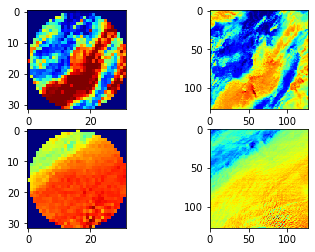

In [15]:
#plt.figure()
fig, ax = plt.subplots(2,2)
for i in range(2):
    ax[i][0].imshow(spatches[i, :,:,0], cmap='jet')
    ax[i][1].imshow(sopatches[i, :,:,0], cmap='jet')
plt.show()
plt.close()

In [106]:
len(np.linspace(0,360, 180+1))

181

Replication and Rotation

In [16]:
def copy_rot_fn(patches, height=None, width=None, ch=None, copy_size=None):
    img_list = []
    for patch in patches:
        img_list.extend([np.reshape(patch, (1,height,width,ch))])
        img_list.extend([ np.expand_dims(np.copy(patch.reshape(height,width,ch)), axis=0) 
                     for i in range(copy_size-1)])
    imgs = np.concatenate(img_list, axis=0)
    print(imgs.shape)
    
    radians = []
    for j in range(patches.shape[0]):
        radians.extend([i*math.pi/180 for i in np.linspace(0,360,copy_size+1) ][:-1] )
    print(len(radians))
    rimgs_tf = rotate_fn(imgs, angles=radians)
    rtest_imgs = tf.keras.backend.eval(rimgs_tf)
    return rtest_imgs

In [129]:
rspatches = copy_rot_fn(spatches, height=32, width=32, ch=6, copy_size=360)

(720, 32, 32, 6)
720


In [130]:
rospatches = copy_rot_fn(sopatches, height=128, width=128, ch=6, copy_size=360)

(720, 128, 128, 6)
720


In [131]:
gc.collect()

21829

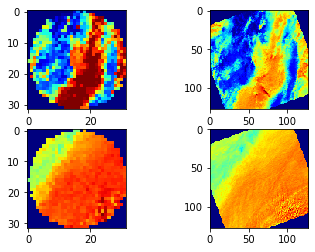

In [20]:
#plt.figure()
fig, ax = plt.subplots(2,2)
for idx, i in enumerate([10,190]):
    ax[idx][0].imshow(rspatches[i, :,:,0], cmap='jet')
    ax[idx][1].imshow(rospatches[i, :,:,0], cmap='jet')
plt.show()
plt.close()

Make labeles

In [134]:
label = np.array([0 for i in range(360)]+[1 for j in range(360)])

In [22]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

---------
### Cross validation

##### RI autoencoder

In [23]:
# 67011582; Best model
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = 67011582
model_dir = os.path.join(model_datadir,str(expname) )
encoder = load_latest_model(model_dir, mtype='encoder')

 Load encoder at 100 epoch


SVM

In [160]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.0428102  0.042449   0.03718114]
score_time [0.02959776 0.02359605 0.02604604]
test_precision_macro [1.         0.88461538 0.93478261]
test_recall_macro [1.    0.85  0.925]


MLP

In [162]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


fit_time [465.73313999 429.18912554 458.26210046]
score_time [0.19261789 0.18226695 0.19763184]
test_precision_macro [0.97619048 1.         0.87974684]
test_recall_macro [0.975      1.         0.84166667]


RandomForest

In [165]:
scoring = ['precision_macro', 'recall_macro']
clf =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.01096535 0.00961328 0.00961399]
score_time [0.00340557 0.003304   0.00328159]
test_precision_macro [0.72859704 0.80841901 0.87037037]
test_recall_macro [0.64166667 0.80833333 0.825     ]


AdaBoost

In [166]:
scoring = ['precision_macro', 'recall_macro']
clf =  AdaBoostClassifier()
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [2.10979724 1.99257231 1.99868393]
score_time [0.02232766 0.02120781 0.02143884]
test_precision_macro [0.59169214 0.81578947 0.65111111]
test_recall_macro [0.59166667 0.70833333 0.64166667]


##### NRI autoencoder

In [32]:
# 'm2_02_global_2000_2018_band28_29_31'
model_datadir = '/home/tkurihana/rotate_invariant/stepbystep/transform/output_model'
expname = 'm2_02_global_2000_2018_band28_29_31'
model_dir = os.path.join(model_datadir,str(expname) )
nriencoder = load_latest_model(model_dir, mtype='encoder')

 Load encoder at 100000 epoch


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


-------------
Compute where is the similar descriptor

In [153]:
all_encs = nriencoder.predict(opatches)

In [146]:
a = np.concatenate( [all_encs[:759], all_encs[760:] ], axis=0 )
print(a.shape)
n,h,w,c = a.shape
b = np.sum(np.square(a.reshape(n, h*w*c) - all_encs[759].reshape(1, h*w*c) ), axis=1)
#b.shape
np.argmin(b, axis=0 )#

(1999, 8, 8, 128)


1925

Compute for other patches

09/10 midnight memo: Need to record square distance and choose first 100 smallest pair for comparison

In [158]:
index_list = []
for i in range(2000):
#for _ in range(1):
#    i = 759
    #if i < 1999:
    #    a = np.concatenate( [all_encs[:i], all_encs[i+1:] ], axis=0 )
    #elif i == 1999:
    #    a =all_encs[:i]
    #print(a.shape)
    n,h,w,c = all_encs.shape
    b = np.sum(np.square(all_encs.reshape(n, h*w*c) - all_encs[i].reshape(1, h*w*c) ), axis=1)
    #b.shape
    #sid = np.argmin(b, axis=0 )#
    #if sid >
    bb = b.argsort()
    index_list.append(bb[1])

In [160]:
index_list[759]

1926

In [163]:
# save the pair patch information
with open('./pair_index.txt', 'w') as f:
    for idx in index_list:
        f.write(str(idx)+'\n')

In [168]:
# save the pair patch information
with open('./pair_index.txt', 'r') as f:
    data = []
    lines = f.read().split('\n')
    for line in lines:
        if len(line) > 0:
            data.append(int(line))

----------------

In [161]:
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.28965068 0.23191428 0.22873044]
score_time [0.22399664 0.18026686 0.18302131]
test_precision_macro [0.81914894 0.81914894 0.81578947]
test_recall_macro [0.71666667 0.71666667 0.70833333]


In [170]:
scoring = ['precision_macro', 'recall_macro']
#clf =  GaussianProcessClassifier(1.0 * RBF(1.0))
clf =  MLPClassifier(alpha=1, max_iter=1000)
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fit_time [1115.80123019  390.20564508  610.94924712]
score_time [0.42552495 0.45352936 0.40470314]
test_precision_macro [0.77522936 0.25       0.79126214]
test_recall_macro [0.59166667 0.5        0.64166667]


In [168]:
scoring = ['precision_macro', 'recall_macro']
clf =  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.01555943 0.00985432 0.00975084]
score_time [0.00418973 0.00356746 0.00350118]
test_precision_macro [0.88222222 0.95454545 0.99180328]
test_recall_macro [0.85833333 0.95       0.99166667]


In [169]:
scoring = ['precision_macro', 'recall_macro']
clf =  AdaBoostClassifier()
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
sorted(scores.keys())
for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
    print(ikey, scores[ikey])

fit_time [0.23654938 0.19737792 0.19646788]
score_time [0.00362754 0.00360727 0.00359249]
test_precision_macro [0.73809524 0.92253521 0.89473684]
test_recall_macro [0.7        0.90833333 0.86666667]


---------------------
### Cross validation with ROC curve

In [26]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

- RI Autoencoder

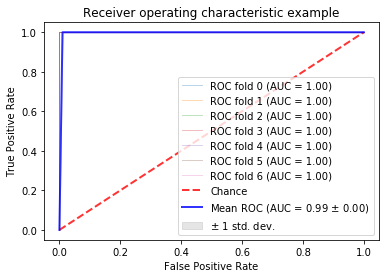

In [143]:
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
X_train, X_test, y_train, y_test = train_test_split(encs.reshape(n, h*w*c), label, test_size=.5, random_state=0)

cv = StratifiedKFold(n_splits=7)
classifier = svm.SVC(kernel='linear', probability=True,C=1, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_train, y_test)):
    classifier.fit(X_train[train], y_train[train])
    viz = plot_roc_curve(classifier, X_test[test], y_test[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [139]:
# shuffle and split training and test sets
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
X_train, X_test, y_train, y_test = train_test_split(encs.reshape(n, h*w*c), label, test_size=.5, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
#n_classes = 
#for i in range(n_classes):
i = 0
fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [140]:
fpr

{0: array([0., 0., 0., 1.]), 'micro': array([0., 0., 0., 1.])}

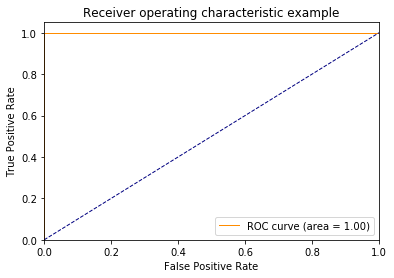

In [141]:
plt.figure()
lw = 1
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [144]:
# shuffle and split training and test sets
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
X_train, X_test, y_train, y_test = train_test_split(encs.reshape(n, h*w*c), label, test_size=.3, random_state=0)
classifier = clf = svm.SVC(kernel='linear', C=1, random_state=0)
classifier.fit(X_train, y_train)
y_score = classifier.decision_function(X_test)

In [145]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 1.00


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

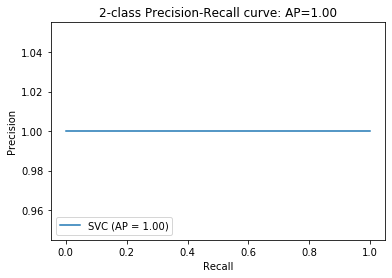

In [146]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


----------------
Practice for precision-recall curve

In [ ]:
#test_precision_macro [1.         0.88461538 0.93478261]
#test_recall_macro [1.    0.85  0.925]
#test_precision_macro [0.97619048 1.         0.87974684]
#test_recall_macro [0.975      1.         0.84166667]

In [117]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [172]:
from sklearn.model_selection import cross_val_predict
scoring = ['accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision','roc_auc', ]
clf = svm.SVC(kernel='linear', C=1, random_state=0,probability=True)
encs = encoder.predict(rspatches)
n,h,w,c = encs.shape
#scores = cross_val_predict(clf, encs.reshape(n, h*w*c), label, cv=3,method="decision_function")
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
#sorted(scores.keys())
#for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
#    print(ikey, scores[ikey])

In [125]:
scores

{'fit_time': array([0.18272734, 0.16489601, 0.17825198]),
 'score_time': array([0.03124642, 0.02666759, 0.02872705]),
 'test_accuracy': array([1.   , 0.85 , 0.925]),
 'test_precision': array([1.        , 0.76923077, 0.86956522]),
 'test_recall': array([1., 1., 1.]),
 'test_f1': array([1.        , 0.86956522, 0.93023256]),
 'test_average_precision': array([1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1.])}

In [173]:
scores

{'fit_time': array([0.59460664, 0.56198645, 0.55058813, 0.55309415, 0.56774044]),
 'score_time': array([0.03430271, 0.0378027 , 0.03688693, 0.03876686, 0.04018784]),
 'test_accuracy': array([1.        , 0.95138889, 1.        , 1.        , 1.        ]),
 'test_precision': array([1.        , 0.91139241, 1.        , 1.        , 1.        ]),
 'test_recall': array([1., 1., 1., 1., 1.]),
 'test_f1': array([1.        , 0.95364238, 1.        , 1.        , 1.        ]),
 'test_average_precision': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1., 1., 1.])}

In [78]:
average_precision_score(label, scores)

0.9999999999999999

In [ ]:
y_score = classifier.decision_function(X_test)

In [110]:
p = [1, 0.88461538, 0.93478261,1, 0.88461538, 0.93478261, 0.7]
r = [1., 0.85, 0.925, 1.   , 0.85 , 0.925, 0.7]
pp = np.interp(mean_fpr,r, p)


In [105]:
r,p

([1.0, 0.85, 0.925, 1.0, 0.85, 0.925],
 [1, 0.88461538, 0.93478261, 1, 0.88461538, 0.93478261])

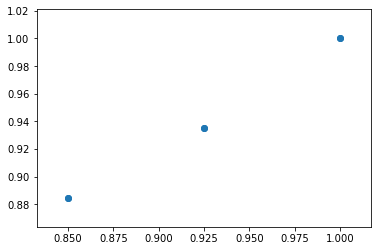

In [106]:
plt.scatter(r,p)

In [107]:
pp, p, r

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.  

Text(0, 0.5, 'precision')

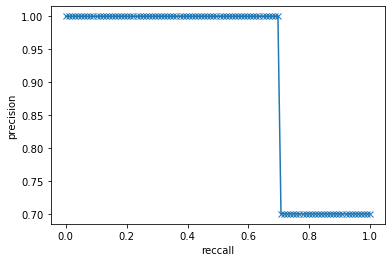

In [114]:
average_precision
plt.plot(mean_fpr, pp, '-x')
plt.xlabel('reccall')
plt.ylabel('precision')

NRI - SVM

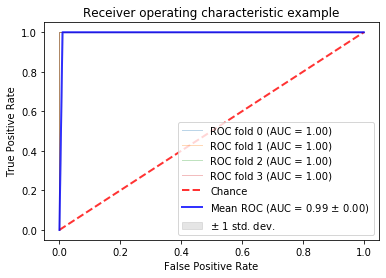

In [38]:
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
X_train, X_test, y_train, y_test = train_test_split(encs.reshape(n, h*w*c), label, test_size=.5, random_state=0)

cv = StratifiedKFold(n_splits=4)
classifier = svm.SVC(kernel='linear', probability=True,C=1, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X_train, y_test)):
    classifier.fit(X_train[train], y_train[train])
    viz = plot_roc_curve(classifier, X_test[test], y_test[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [127]:
#from sklearn.model_selection import cross_val_predict
scoring = ['accuracy',
        'precision',
        'recall',
        'f1',
        'average_precision','roc_auc', ]
clf = svm.SVC(kernel='linear', C=1, random_state=0,probability=True)
encs = nriencoder.predict(rospatches)
n,h,w,c = encs.shape
#scores = cross_val_predict(clf, encs.reshape(n, h*w*c), label, cv=3,method="decision_function")
scores = cross_validate(clf, encs.reshape(n, h*w*c), label, cv=3, scoring=scoring)
#sorted(scores.keys())
#for ikey in ['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']:
#    print(ikey, scores[ikey])

In [126]:
scores

{'fit_time': array([0.18272734, 0.16489601, 0.17825198]),
 'score_time': array([0.03124642, 0.02666759, 0.02872705]),
 'test_accuracy': array([1.   , 0.85 , 0.925]),
 'test_precision': array([1.        , 0.76923077, 0.86956522]),
 'test_recall': array([1., 1., 1.]),
 'test_f1': array([1.        , 0.86956522, 0.93023256]),
 'test_average_precision': array([1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1.])}

In [128]:
scores

{'fit_time': array([1.46929288, 1.44450974, 1.51003265]),
 'score_time': array([0.19366455, 0.18715286, 0.18642998]),
 'test_accuracy': array([0.71666667, 0.71666667, 0.70833333]),
 'test_precision': array([0.63829787, 0.63829787, 0.63157895]),
 'test_recall': array([1., 1., 1.]),
 'test_f1': array([0.77922078, 0.77922078, 0.77419355]),
 'test_average_precision': array([1., 1., 1.]),
 'test_roc_auc': array([1., 1., 1.])}

##### Check pickle data

In [3]:
import pickle
with open('./cross_validation/67011582/cv-3/SVM/scores_4433776-0.pkl', 'rb') as handle:
    b = pickle.load(handle)

In [4]:
b

{'idx-759': {'fit_time': array([0.15966725, 0.15642023, 0.14374208]),
  'score_time': array([0.09984303, 0.09586   , 0.09673667]),
  'test_accuracy': array([0.99583333, 0.83333333, 0.8625    ]),
  'test_precision': array([0.99173554, 0.75      , 0.78431373]),
  'test_recall': array([1., 1., 1.]),
  'test_f1': array([0.99585062, 0.85714286, 0.87912088]),
  'test_average_precision': array([1., 1., 1.]),
  'test_roc_auc': array([1., 1., 1.])},
 'idx-852': {'fit_time': array([0.30027294, 0.19609547, 0.19750118]),
  'score_time': array([0.12302899, 0.10895753, 0.11574221]),
  'test_accuracy': array([1., 1., 1.]),
  'test_precision': array([1., 1., 1.]),
  'test_recall': array([1., 1., 1.]),
  'test_f1': array([1., 1., 1.]),
  'test_average_precision': array([1., 1., 1.]),
  'test_roc_auc': array([1., 1., 1.])},
 'idx-765': {'fit_time': array([0.20697618, 0.12135887, 0.12008953]),
  'score_time': array([0.09803343, 0.08307099, 0.09532452]),
  'test_accuracy': array([1., 1., 1.]),
  'test_pre